In [2]:
from keras.metrics import mean_squared_error
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from typing import Tuple
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense, MaxPooling1D, Conv1D, UpSampling1D, Reshape, TimeDistributed, Bidirectional

In [3]:
# Constants
INPUT_FEATURES = 26                # Number of input features (e.g., temperature, humidity, etc.)
SEQUENCE_LEN = 7 * 24              # 7 days of hourly data
OUTPUT_LEN = 1 * 24                # 24 hours in the next day
OUTPUT_FEATURES = 4 * OUTPUT_LEN   # Predicting 3 features for each day
LSTM_UNITS = 128                   # Number of LSTM units
DENSE_UNITS = 128                  # Number of Dense layer units
DROPOUT_RATE = 0.2                 # Dropout rate

In [28]:
def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LEN - OUTPUT_LEN):
        X.append(data[i: i + SEQUENCE_LEN])
        y.append(data[i + SEQUENCE_LEN: i + SEQUENCE_LEN + OUTPUT_LEN, :4].flatten()) # Taking the first 3 features for the next 24 hours
    return np.array(X), np.array(y)


def invert_scale(data, scaler):
    copy_data = data.copy()
    for i in range(4):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_data[:, i::4] = data[:, i::4] * std + mean
    return copy_data


def MSE(y_true, y_pred):
    T_mse = np.mean((y_true[:, 0::4] - y_pred[:, 0::4])**2, axis=0).reshape(1, -1)
    P_mse = np.mean((y_true[:, 1::4] - y_pred[:, 1::4])**2, axis=0).reshape(1, -1)
    WD_mse = np.mean((y_true[:, 2::4] - y_pred[:, 2::4])**2, axis=0).reshape(1, -1)
    WV_mse = np.mean((y_true[:, 3::4] - y_pred[:, 3::4])**2, axis=0).reshape(1, -1)
    MSE_by_hour = np.append(np.append(np.append(T_mse, P_mse, axis=0), WD_mse, axis=0), WV_mse, axis=0)
    
    return MSE_by_hour, np.mean(MSE_by_hour, axis=1), np.mean(MSE_by_hour)


def plot_one_prediction(idx: int, X_true, y_true, y_pred, figsize: Tuple[int] = (15, 10)):
    x = range(SEQUENCE_LEN + OUTPUT_LEN)
    x1, x2 = x[1:1 + SEQUENCE_LEN], x[SEQUENCE_LEN:]
    labels = ['Temperature [C]', 'Pressure [hPa]', 'Wind direction [o]', 'Wind velocity [m/s]']

    fig, axs = plt.subplots(4, figsize=figsize)
    fig.suptitle('Weather Forecast: Actual vs Predicted')
    for i in range(4):
        axs[i].plot(x1, X_true[idx + 1, :, i], label='Given data', color='green')
        axs[i].plot(x2, y_true[:, i::4][idx], label='Actual', color='blue')
        axs[i].plot(x2, y_pred[:, i::4][idx], label='Predicted', color='red')
        axs[i].set_ylabel(labels[i])
        axs[i].grid()
        axs[i].legend()
    axs[3].set_xlabel('Time (Hours)')
    plt.show()

In [18]:
data = pd.read_csv('../data/preprocessed_data/complete_krk_2017-22.csv')
data = data.drop('timestamp', axis=1)
cols = data.columns
new_order = [0, 1, 10, 11] + list(range(2, 10)) + list(range(12, 26))
cols = [cols[i] for i in new_order]
data = data[cols]
data

,Temperatura powietrza [°C]/1,Ciśnienie na poziomie stacji [hPa],Kierunek wiatru [°],Prędkość wiatru [m/s],Opad godzinowy [mm],Wysokość podstawy chmur CL CM szyfrowana [kod],Chmury CL [kod],Chmury CM [kod],Chmury CH [kod],Widzialność operatora [m],...,Ciśnienie pary wodnej [hPa],Charakterystyka tendencji [kod],Wartość tendencji [wartość],Rodzaj opadu za 6 godzin [kod],Stan gruntu [kod],Wystąpienie rosy [0/1],Równoważnik wodny śniegu [mm/cm],Wysokość pokrywy śnieżnej [cm],Wysokość świeżo spadłego śniegu [cm],Gatunek śniegu [kod]
0,-6.8,995.8,357,1,0.0,9,0,0,0,3500,...,3.5,7,-1.5,0,4,0,0.0,0.0,0.0,0
1,-6.9,995.6,98,1,0.0,9,0,0,0,3500,...,3.5,6,-1.4,0,0,0,0.0,0.0,0.0,0
2,-3.9,994.9,205,3,0.0,9,0,0,0,5000,...,3.8,7,-1.4,0,0,0,0.0,0.0,0.0,0
3,-6.5,994.1,211,2,0.0,9,0,0,0,4000,...,3.5,8,-1.7,0,0,0,0.0,0.0,0.0,0
4,-6.1,993.6,168,1,0.0,9,0,0,0,4000,...,3.3,7,-2.0,0,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,8.3,991.2,250,3,0.0,9,0,0,0,20000,...,9.5,1,0.7,0,0,0,0.0,0.0,0.0,0
52580,9.1,991.4,236,3,0.0,9,0,0,0,20000,...,9.2,2,0.5,0,0,0,0.0,0.0,0.0,0
52581,8.4,991.6,200,2,0.0,9,0,0,0,20000,...,9.0,2,0.5,0,0,0,0.0,0.0,0.0,0
52582,9.3,991.6,262,2,0.0,9,0,0,0,20000,...,8.7,1,0.4,0,0,0,0.0,0.0,0.0,0


In [19]:
# Assuming 'data' is your dataset with shape (total_hours, 26_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[-1.84487084,  0.96334401,  1.82251366, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.85603007,  0.93829589, -0.5246128 , ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-1.52125303,  0.85062749,  0.44504948, ..., -0.15217187,
        -0.12556201, -0.28491282],
       ...,
       [-0.14866714,  0.43733359,  0.39973816, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.04823402,  0.43733359,  0.96159855, ..., -0.15217187,
        -0.12556201, -0.28491282],
       [-0.40532954,  0.42480953, -0.27993166, ..., -0.15217187,
        -0.12556201, -0.28491282]])

In [20]:
# Create sequences
X, y = create_sequences(data_normalized)

In [21]:
train_size = 24 * (365 * 3 + 366)
val_size = 24 * 365

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [22]:
input_layer = Input(shape=(168, 26))  # 7 days * 24 hours, 26 parameters

reshape = Reshape((26, 168)) (input_layer)
# Downsampling
conv1 = Conv1D(filters=128, kernel_size=7, activation='relu', strides=1, padding="causal") (reshape)
lstm1 = Bidirectional(LSTM(128, return_sequences=True))(conv1)

lstm2 = Bidirectional(LSTM(64, return_sequences=False))(lstm1)

# Output layer
output_layer = Dense(96, activation='linear') (lstm2)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust optimizer and loss as needed
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 26)]         0         
                                                                 
 reshape (Reshape)           (None, 26, 168)           0         
                                                                 
 conv1d (Conv1D)             (None, 26, 128)           150656    
                                                                 
 bidirectional (Bidirection  (None, 26, 256)           263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 96)                12384 

In [23]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
1096/1096 [==============================] - 89s 75ms/step - loss: 0.4275 - val_loss: 0.4618
Epoch 2/20
1096/1096 [==============================] - 72s 66ms/step - loss: 0.2906 - val_loss: 0.4838
Epoch 3/20
1096/1096 [==============================] - 168s 153ms/step - loss: 0.2273 - val_loss: 0.4903
Epoch 4/20
1096/1096 [==============================] - 67s 61ms/step - loss: 0.1982 - val_loss: 0.4962
Epoch 5/20
1096/1096 [==============================] - 67s 61ms/step - loss: 0.1825 - val_loss: 0.5016
Epoch 6/20
1096/1096 [==============================] - 66s 60ms/step - loss: 0.1727 - val_loss: 0.5060
Epoch 7/20
1096/1096 [==============================] - 66s 61ms/step - loss: 0.1650 - val_loss: 0.5089
Epoch 8/20
1096/1096 [==============================] - 66s 60ms/step - loss: 0.1598 - val_loss: 0.5091
Epoch 9/20
1096/1096 [==============================] - 66s 60ms/step - loss: 0.1553 - val_loss: 0.5148
Epoch 10/20
1096/1096 [==============================] - 65s 6

In [27]:
model.save('CNN&LSTM_wind_29-12-2023_baseline')

INFO:tensorflow:Assets written to: CNN&LSTM_wind_29-12-2023_baseline\assets


INFO:tensorflow:Assets written to: CNN&LSTM_wind_29-12-2023_baseline\assets


In [18]:
from keras.models import load_model

model = load_model('CNN&LSTM_29-12-2023_baseline')
history = model.history

In [37]:
loss = history["loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

TypeError: 'History' object is not subscriptable

In [25]:
# Make predictions
y_pred = model.predict(X_test)

268/268 [==============================] - 7s 21ms/step


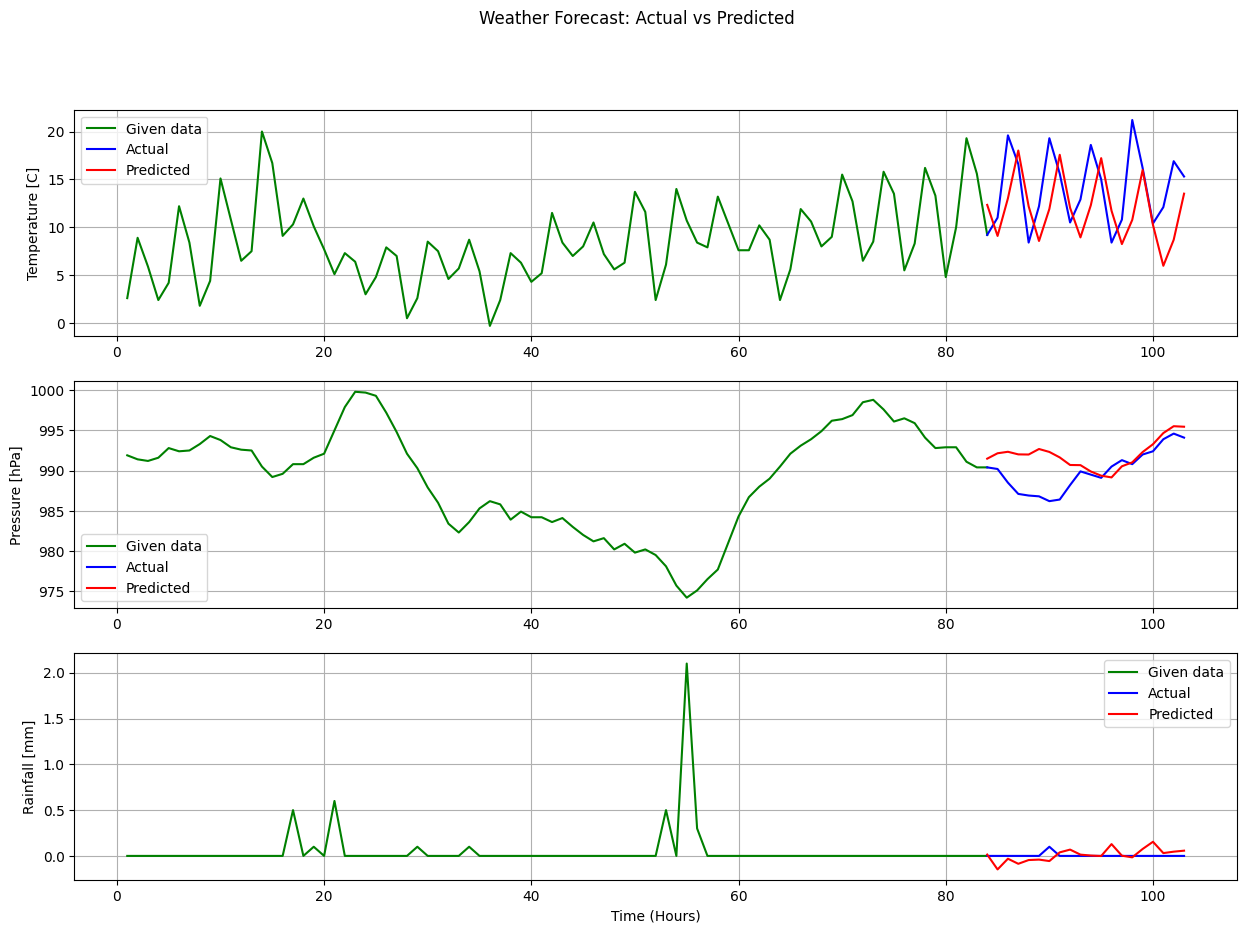

In [59]:
plot_one_prediction(400, X_test, y_test, y_pred, scaler)

In [32]:
MSE(invert_scale(y_test, scaler), invert_scale(y_pred, scaler))[0]

array([[5.61485659e+00, 5.89511779e+00, 6.30448605e+00, 6.77792972e+00,
        7.31283931e+00, 7.80929322e+00, 8.30452665e+00, 8.75551847e+00,
        9.16041641e+00, 9.48583425e+00, 9.72585453e+00, 9.93129147e+00,
        1.01391666e+01, 1.04008777e+01, 1.06732094e+01, 1.10161826e+01,
        1.13875525e+01, 1.17939627e+01, 1.22692257e+01, 1.27007404e+01,
        1.30722791e+01, 1.34129509e+01, 1.36841384e+01, 1.38449602e+01],
       [3.86263172e+00, 4.04779564e+00, 4.39253509e+00, 4.89323596e+00,
        5.53874559e+00, 6.32721388e+00, 7.24545806e+00, 8.29897967e+00,
        9.49097188e+00, 1.07928818e+01, 1.22102251e+01, 1.37177844e+01,
        1.53085326e+01, 1.69893144e+01, 1.87255721e+01, 2.04774825e+01,
        2.22687487e+01, 2.40639135e+01, 2.58928581e+01, 2.76950242e+01,
        2.94812217e+01, 3.12918740e+01, 3.31220538e+01, 3.48800098e+01],
       [8.27317062e+03, 8.87247634e+03, 9.15728754e+03, 9.43076889e+03,
        9.85362100e+03, 1.03155263e+04, 1.06191578e+04, 1.0717

In [33]:
MSE(invert_scale(y_test, scaler), invert_scale(y_pred, scaler))[1]

array([9.97805044e+00, 1.62922943e+01, 1.11603120e+04, 4.24685318e+00])